## For new strategy images

In [1]:
import numpy as np
import pandas as pd
import pickle
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import ImageGrid
import matplotlib.image as mpimg
import torchvision.transforms as transforms
import sys
sys.path.append("/home/jupyter/DIG-In/src/vit_patching/models")
import patch_utils as pu
np.random.seed(42)
import get_patch_ViT16_features_v1 as gp
from lang_sam import LangSAM
from PIL import Image
import torch
import copy

In [2]:
import torchvision.transforms.functional as F

In [3]:
model = LangSAM()

/opt/conda/envs/langsam2/lib/python3.8/site-packages/torch/functional.py:504: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at ../aten/src/ATen/native/TensorShape.cpp:3483.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


final text_encoder_type: bert-base-uncased
Model loaded from /home/jupyter/.cache/huggingface/hub/models--ShilongLiu--GroundingDINO/snapshots/a94c9b567a2a374598f05c584e96798a170c56fb/groundingdino_swinb_cogcoor.pth 
 => _IncompatibleKeys(missing_keys=[], unexpected_keys=['label_enc.weight', 'bert.embeddings.position_ids'])


In [4]:
full_img_root = "/home/jupyter/geode/images"
full_img_gen_root = "/home/jupyter/696DS-data/generated"

In [5]:
objects_file="/home/jupyter/DIG-In/data/seg_low_patches_removed_objects.pkl"
geode_file = "/home/jupyter/DIG-In/data/geode_27_objects.csv"
gen_file = "/home/jupyter/DIG-In/pipeline/data/prompting_2/processed_df_geode_gen.csv"

In [6]:
with open(objects_file, 'rb') as f:
    objects = pickle.load(f)
objects

['jug',
 'car',
 'plate_of_food',
 'chair',
 'lighter',
 'toy',
 'dustbin',
 'toothbrush',
 'toothpaste_toothpowder',
 'medicine',
 'light_switch',
 'dog',
 'front_door',
 'cooking_pot',
 'bicycle',
 'tree',
 'bag',
 'spices',
 'hairbrush_comb',
 'hat',
 'candle']

In [7]:
considered_objs = ["dog", "car"]


In [8]:
geode_df = pd.read_csv(geode_file)
gen_df = pd.read_csv(gen_file)

In [9]:
img_size = 224
n_patches = 224 // 16
transforms_list = transforms.Compose([
        gp.CenterCropLongEdge(),
        transforms.Resize(img_size),  # Use dynamic img_size based on the model
        transforms.ToTensor(),
        # TRANSFORM_NORMALIZE
    ])
    
preprocessor1 = transforms_list
preprocessor2 = gp.TRANSFORM_NORMALIZE

In [10]:
def plot_sampled_images(image_paths, obj, save_fig_name="test.png", save_fig = False):
    assert len(image_paths)==9, "can grid only 9 images"
    # sample generations
    # fig = plt.figure(figsize=(3.6, 3.6))
    # grid = ImageGrid(fig, 111,  # similar to subplot(111)
    #                 nrows_ncols=(3, 3),  # creates 2x2 grid of axes
    #                 axes_pad=0.05,  # pad between axes in inch.

    #                 )
    # images = []
    fig, axs = plt.subplots(3, 3, figsize=(9, 9))
    plt.subplots_adjust(wspace=0.02, hspace=0.02)
    for i in range(9):

        image_pil = Image.open(image_paths[i])
        masks, boxes, phrases, logits = model.predict(image_pil, obj)

        # print(masks)
        # break

        merged_tensor = torch.any(masks, dim=0, keepdim=True)
        numpy_mask = merged_tensor.squeeze().numpy()
        img, patch_mask = gp.relevant_image_and_patch_mask(image_pil, numpy_mask, 224 //16, preprocessor1, do_obj_seg=False, use_compliment_for_BG=True, use_blackened=False)
        img2 = copy.deepcopy(img)
        img3 = gp.mask_image(img2, patch_mask[0], filler_val=0.99)
        img3 = F.to_pil_image(img3)
        idx=i
        axs[idx // 3,idx%3].imshow(img3)
        axs[idx // 3,idx%3].set_xticks([], [])
        axs[idx // 3,idx%3].set_yticks([], [])
        
        
        axs[idx // 3,idx%3].spines['top'].set_visible(False)
        axs[idx // 3,idx%3].spines['right'].set_visible(False)
        axs[idx // 3,idx%3].spines['bottom'].set_visible(False)
        axs[idx // 3,idx%3].spines['left'].set_visible(False)
    # axs[1, 0].set_ylabel(f'{region}', fontsize=25)
    # axs[0, 1].set_title(f"{title}", fontsize=25)
    if save_fig:
        plt.savefig(save_fig_name,bbox_inches='tight')
    plt.show()
        # img3 - PyTorch tensor, needs to be converted to a PIL image
    #     images.append(transforms.ToPILImage()(img3))

    # for ax, im in zip(grid, images):
    #     # Iterating over the grid returns the Axes.
    #     ax.imshow(im)
    #     ax.axis('off')


    
    # if save_fig:
    #     plt.savefig(save_fig_name)
    # plt.show()
    # plt.axis('off')

In [11]:
Images_objects = {
    "real":[],
    "fake": []
}

In [18]:
# import json

In [17]:
seg_file = "./bg_only_sampled_images_new_strategy.json"
with open(seg_file, 'r') as f:
    data = json.load(f)

In [70]:
# np.random.seed(42)

In [12]:
# considered_regions = ['Europe', 'Africa', 'WestAsia'
#                      #  'SouthEastAsia',
#                     #    'Americas', 'EastAsia'
#                        ]
# considered_objs = ["dog", "car"]

# df = geode_df
# i = 0
# for obj in considered_objs:
#     print(obj)
#     print(considered_regions)
#     for region in considered_regions:
#         temp = df[(df["object"]==obj)*(df["region"]==region)]
#         # file_paths = np.array(temp["file_path"].values)
#         # sampled = np.random.choice(file_paths, replace=False, size=(9))
#         # sampled = list(sampled)
#         # sampled = [f"{full_img_root}/{samp}" for samp in sampled]
#         sampled=data['real'][i]
#         i += 1
#         Images_objects["real"].append(sampled)
#         # print(f"{obj} - {region}")
#         plot_sampled_images(sampled, obj, save_fig=True, save_fig_name=f"./geode/{obj}-{region}.png")
        
        

In [13]:
np.random.seed(42)

dog
['Africa', 'Europe', 'West Asia']


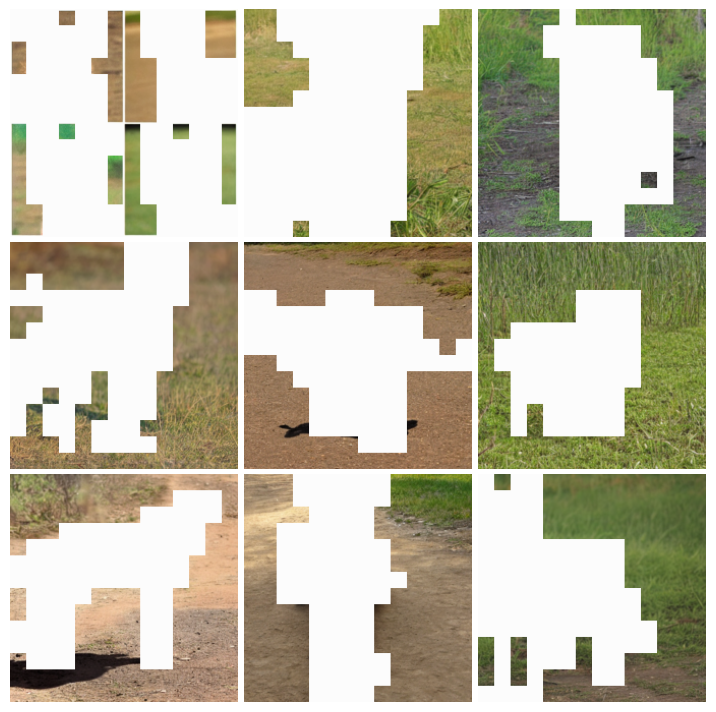

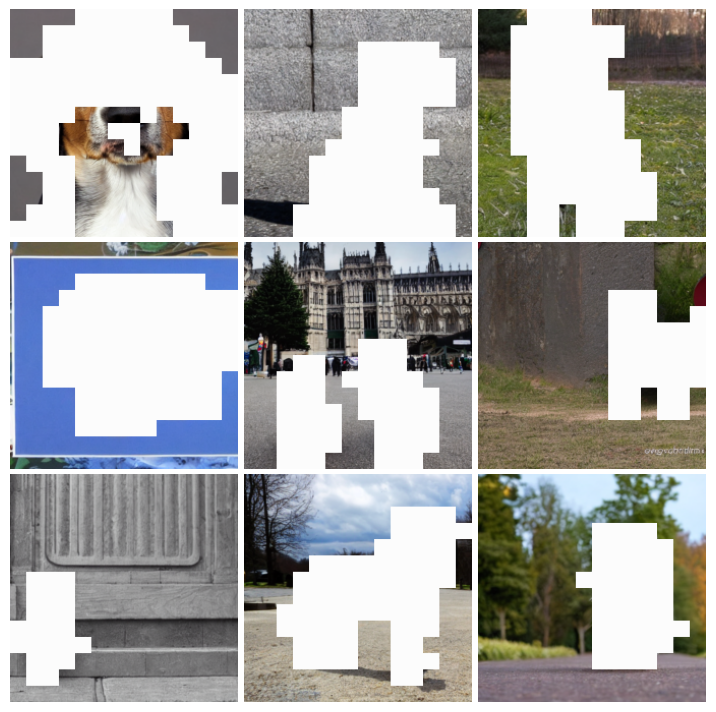

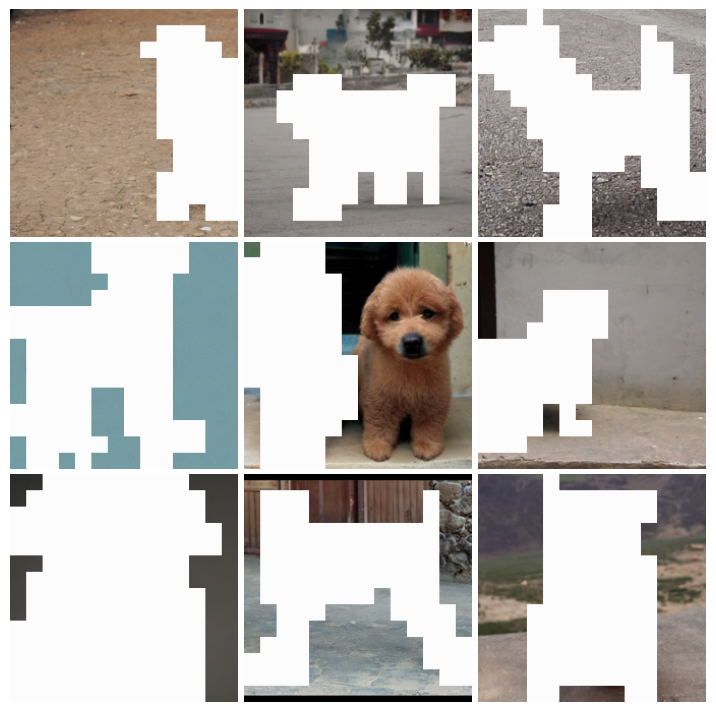

car
['Africa', 'Europe', 'West Asia']


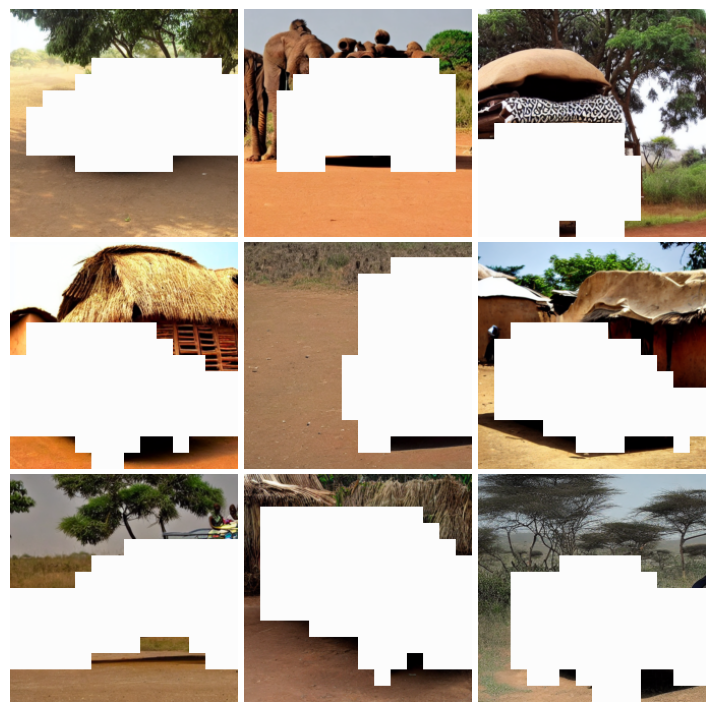

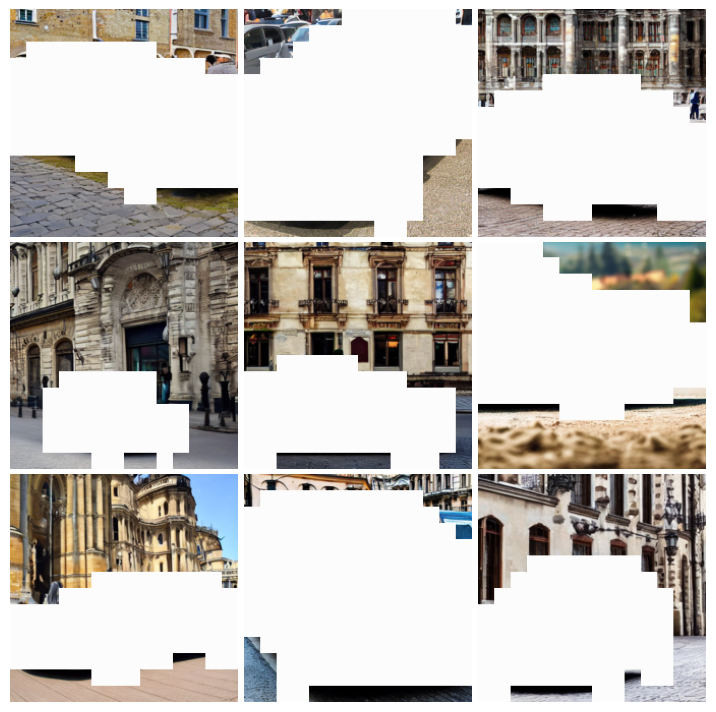

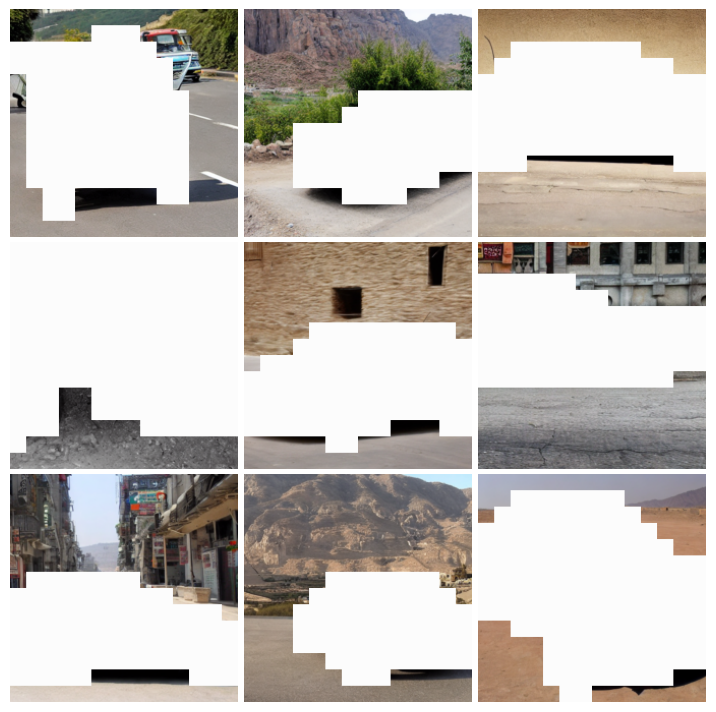

In [18]:
considered_regions = ["Africa", "Europe", 'West Asia']
df = gen_df
i=0
for obj in considered_objs:
    print(obj)
    print(considered_regions)
    for region in considered_regions:
        temp = df[(df["object"]==obj)*(df["region"]==region)]
        # file_paths = np.array(temp["file_path"].values)
        # sampled = np.random.choice(file_paths, replace=False, size=(9))
        # sampled = list(sampled)
        # sampled = [f"{full_img_gen_root}/{samp}" for samp in sampled]
        # Images_objects["fake"].append(sampled)
        # print(f"{obj} - {region}")
        sampled=data['fake'][i]
        i += 1
        plot_sampled_images(sampled,obj, save_fig=True, save_fig_name=f"./generated-new/{obj}-{region}.png")

        

In [16]:
import json
with open("./bg_only_sampled_images_new_strategy.json", 'w') as f:
    json.dump(Images_objects, f)

### For object region

In [19]:
considered_objs = ["bag", "car"]

In [20]:
def plot_sampled_images_obj_only(image_paths, obj, save_fig_name="test.png", save_fig = False):
    assert len(image_paths)==9, "can grid only 9 images"
    # sample generations
    # fig = plt.figure(figsize=(3.6, 3.6))
    # grid = ImageGrid(fig, 111,  # similar to subplot(111)
    #                 nrows_ncols=(3, 3),  # creates 2x2 grid of axes
    #                 axes_pad=0.05,  # pad between axes in inch.

    #                 )
    # images = []
    fig, axs = plt.subplots(3, 3, figsize=(9, 9))
    plt.subplots_adjust(wspace=0.02, hspace=0.02)
    for i in range(9):

        image_pil = Image.open(image_paths[i])
        masks, boxes, phrases, logits = model.predict(image_pil, obj)

        # print(masks)
        # break

        merged_tensor = torch.any(masks, dim=0, keepdim=True)
        numpy_mask = merged_tensor.squeeze().numpy()
        img, patch_mask = gp.relevant_image_and_patch_mask(image_pil, numpy_mask, 224 //16, preprocessor1, do_obj_seg=True, use_compliment_for_BG=True, use_blackened=False)
        img2 = copy.deepcopy(img)
        img3 = gp.mask_image(img2, patch_mask[0], filler_val=0.99)
        img3 = F.to_pil_image(img3)
        idx=i
        axs[idx // 3,idx%3].imshow(img3)
        axs[idx // 3,idx%3].set_xticks([], [])
        axs[idx // 3,idx%3].set_yticks([], [])
        
        
        axs[idx // 3,idx%3].spines['top'].set_visible(False)
        axs[idx // 3,idx%3].spines['right'].set_visible(False)
        axs[idx // 3,idx%3].spines['bottom'].set_visible(False)
        axs[idx // 3,idx%3].spines['left'].set_visible(False)
    # axs[1, 0].set_ylabel(f'{region}', fontsize=25)
    # axs[0, 1].set_title(f"{title}", fontsize=25)
    if save_fig:
        plt.savefig(save_fig_name,bbox_inches='tight')
    plt.show()
        # img3 - PyTorch tensor, needs to be converted to a PIL image
    #     images.append(transforms.ToPILImage()(img3))

    # for ax, im in zip(grid, images):
    #     # Iterating over the grid returns the Axes.
    #     ax.imshow(im)
    #     ax.axis('off')


    
    # if save_fig:
    #     plt.savefig(save_fig_name)
    # plt.show()
    # plt.axis('off')

In [25]:
Images_objects = {
    "real":[],
    "fake": []
}

In [88]:
# seg_file = "./obj_only_sampled_images-new.json"
# with open(seg_file, 'r') as f:
#     data = json.load(f)

In [22]:
np.random.seed(42)

In [24]:
# considered_regions = ['Europe', 'Africa', 'WestAsia'
#                      #  'SouthEastAsia',
#                     #    'Americas', 'EastAsia'
#                        ]
# df = geode_df
# i=0
# for obj in considered_objs:
#     print(obj)
#     print(considered_regions)
#     for region in considered_regions:
#         temp = df[(df["object"]==obj)*(df["region"]==region)]
#         file_paths = np.array(temp["file_path"].values)
#         sampled = np.random.choice(file_paths, replace=False, size=(9))
#         sampled = list(sampled)
#         sampled = [f"{full_img_root}/{samp}" for samp in sampled]
#         Images_objects["real"].append(sampled)
#         # print(f"{obj} - {region}")
#         # sampled=data['real'][i]
#         # i += 1
#         Images_objects["real"].append(sampled)
#         plot_sampled_images_obj_only(sampled, obj, save_fig=True, save_fig_name=f"./geode_obj-new/{obj}-{region}-obj.png")
        
        

In [26]:
np.random.seed(42)

bag
['Africa', 'Europe', 'West Asia']


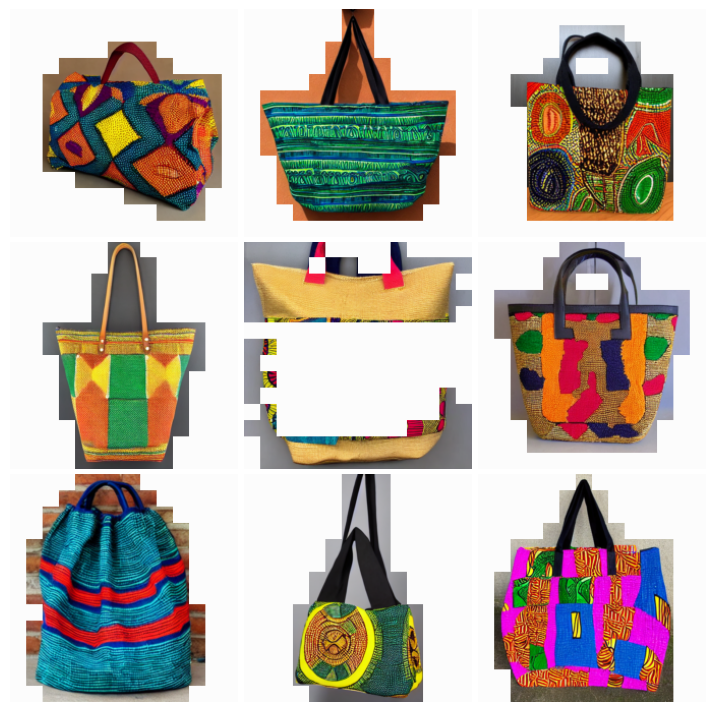

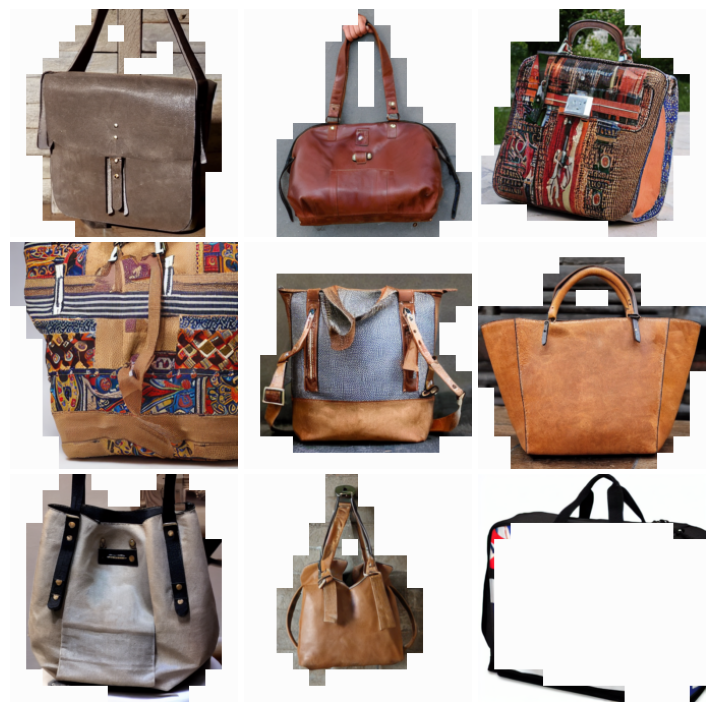

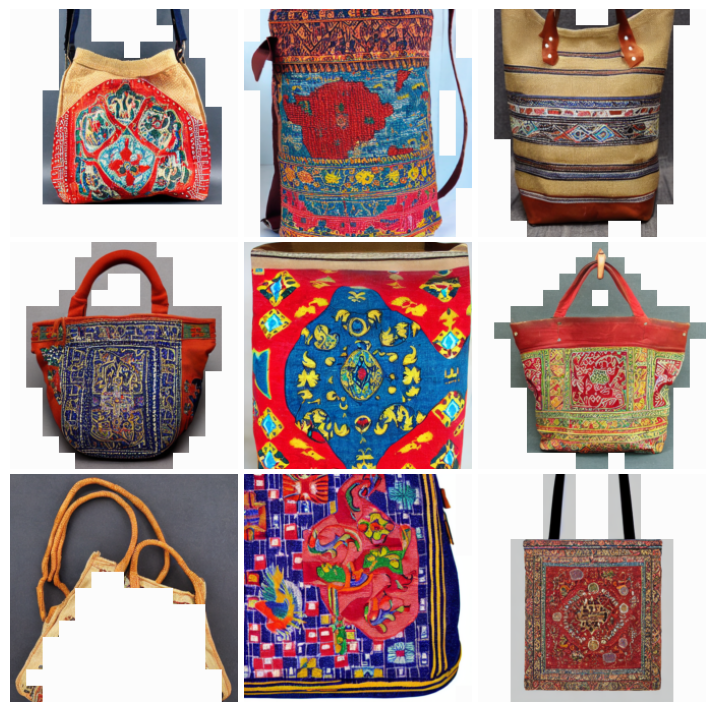

car
['Africa', 'Europe', 'West Asia']


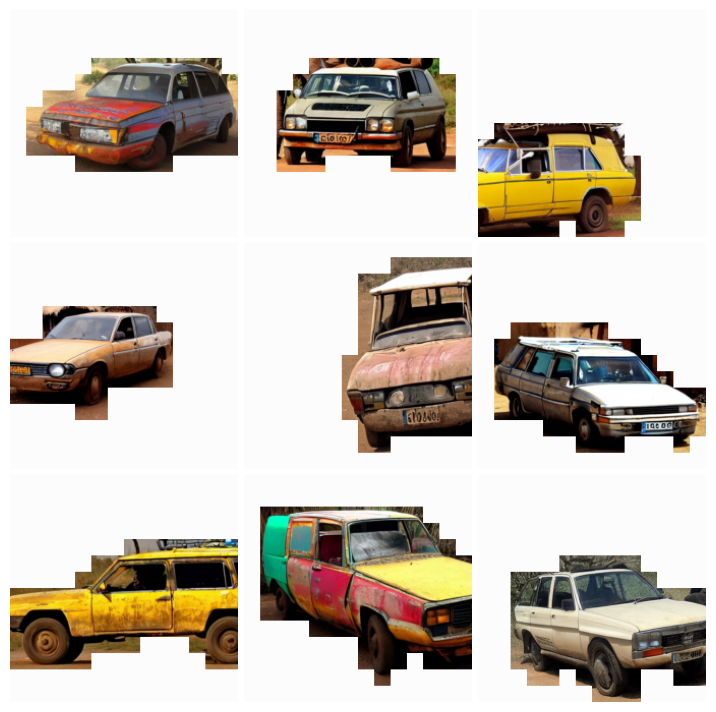

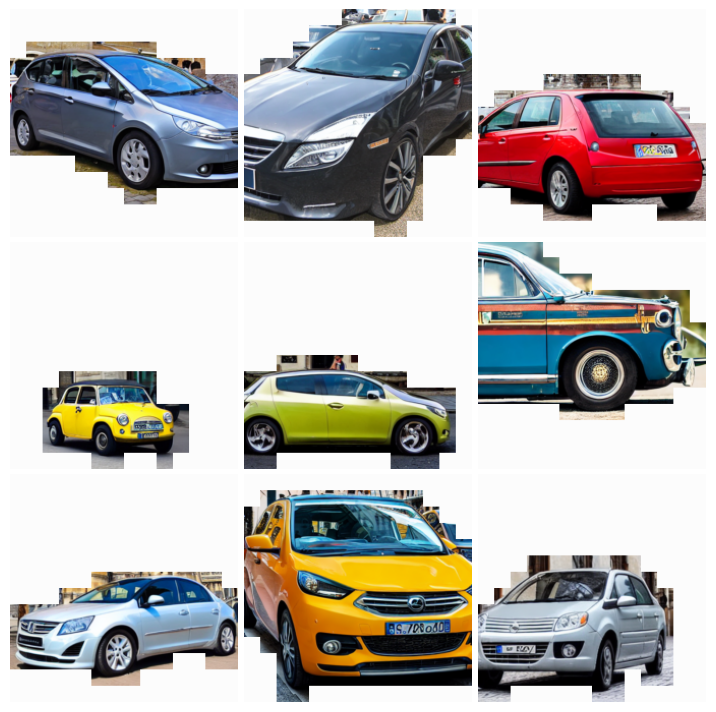

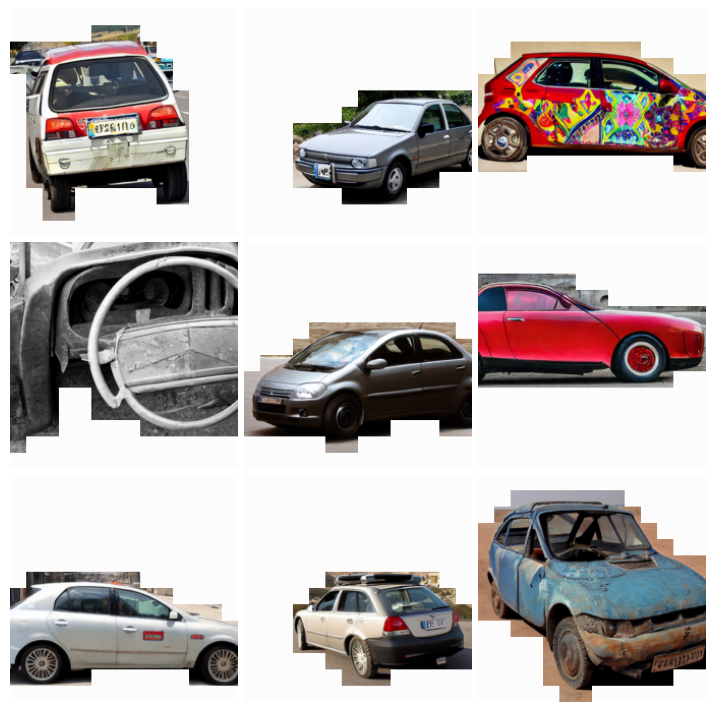

In [27]:
considered_regions = ["Africa", "Europe", 'West Asia']
df = gen_df
i=0
for obj in considered_objs:
    print(obj)
    print(considered_regions)
    for region in considered_regions:
        temp = df[(df["object"]==obj)*(df["region"]==region)]
        file_paths = np.array(temp["file_path"].values)
        sampled = np.random.choice(file_paths, replace=False, size=(9))
        sampled = list(sampled)
        sampled = [f"{full_img_gen_root}/{samp}" for samp in sampled]
        Images_objects["fake"].append(sampled)
        # print(f"{obj} - {region}")
        # sampled=data['fake'][i]
        # i += 1
        plot_sampled_images_obj_only(sampled,obj, save_fig=True, save_fig_name=f"./generated_obj-new/{obj}-{region}-obj.png")

        

In [28]:
with open("./obj_only_sampled_images_new_strategy.json", 'w') as f:
    json.dump(Images_objects, f)